# Goal

3 Questions in mind:

1) How biased are the news outlets?

2) What has been happening in Hong Kong?

3) What topics do different media outlets focus on the most?


Data: News Headlines and Intro from 18 newspapers separated by regions

- China: CCTV, CGTN, Chinadaily, Global Times, Shine_News, Xinhua
- USA: ABC_News, CNN, Fox_News, MSNBC, NBCNews, The New York Times, The Wall Street Journal, The Washington Post, USA_Today
- HK: Hong Kong Free Press, Hong Kong Standard, South China Morning Post



Answered all three question using

1) Sentiment Analysis

2) Topic Modeling

3) Focused Topics by News Outlets of each regions


# Import Libraries

In [2]:
import pandas as pd
import numpy as np
import glob
import unicodedata
import re
import spacy
#python -m spacy download en_core_web_md
import en_core_web_md
nlp = en_core_web_md.load(parse=True, tag=True, entity=True)

from contractions import CONTRACTION_MAP

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import nltk
#nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

# Functions

#### Helper Functions

In [3]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        

# example) do not -> don't. I would -> I'd
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

# standardized into ASCII characters. example) converting é to e
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text 

# Special characters and symbols
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

# JUMPS, JUMPED, and JUMPING -> JUMP
# Multiple Stemmers : PorterStemmer, LancasterStemmer, SnowballStemmer WordNetLemmatizer
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text


def normalize_corpus(corpus, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

# Data Cleaning

In [4]:
# read all pickle files from raw_data folder (raw data from web scraping)
df_news_raw = pd.DataFrame()
for file in glob.glob('raw_data/' + "*"):
    df_news_raw = df_news_raw.append(pd.read_pickle(file), ignore_index=True)

In [5]:
df_news_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1797 entries, 0 to 1796
Data columns (total 5 columns):
publisher    1797 non-null object
title        1797 non-null object
intro        1797 non-null object
link         1797 non-null object
date         1797 non-null object
dtypes: object(5)
memory usage: 70.3+ KB


In [6]:
df_news_raw.columns

Index(['publisher', 'title', 'intro', 'link', 'date'], dtype='object')

In [7]:
# check publishers
df_news_raw['publisher'].value_counts()

South China Morning Post              356
Global Times                          252
Hong Kong Free Press                  237
Xinhua                                143
The New York Times                    116
CNN                                   110
BBC News                              109
ABC News                               61
The Washington Post                    58
Shine News (press release)             52
The Wall Street Journal                52
Chinadaily USA                         41
NBCNews.com                            29
USA Today                              28
Fox News                               28
Wall Street Journal                    26
Washington Post                        24
MSNBC                                  22
Hong Kong Standard (press release)     17
CCTV                                   16
CGTN America                            6
USA TODAY                               4
cgtn.com                                4
CNN International                 

In [8]:
def update_publisher(x):
    if x == 'USA TODAY':
        return 'USA Today'
    if x == 'NBC News':
        return 'NBCNews'
    if x == 'Wall Street Journal (blog)':
        return 'The Wall Street Journal'
    if x == 'CNN International':
        return 'CNN'
    if x == 'CGTN America':
        return 'CGTN'
    if x == 'cgtn.com':
        return 'CGTN'    
    if x == 'Hong Kong Standard (press release)':
        return 'Hong Kong Standard'
    if x == 'Shine News (press release)':
        return 'Shine News'
    if x == 'Wall Street Journal':
        return 'The Wall Street Journal'
    if x == 'Washington Post':
        return 'The Washington Post'
    if x == 'NBCNews.com':
        return 'NBCNews'   
    else:
        return x

In [9]:
def add_regions(x):
    if x == 'South China Morning Post':
        return 'HK'
    if x == 'Global Times':
        return 'CN'
    if x == 'Hong Kong Free Press':
        return 'HK'
    if x == 'Xinhua':
        return 'CN'
    if x == 'The New York Times':
        return 'US'
    if x == 'BBC News':
        return 'UK'
    if x == 'CNN':
        return 'US'
    if x == 'The Washington Post':
        return 'US'
    if x == 'ABC News':
        return 'US'
    if x == 'The Wall Street Journal':
        return 'US'
    if x == 'Shine News':
        return 'CN'
    if x == 'Chinadaily USA':
        return 'CN'
    if x == 'USA Today':
        return 'US'
    if x == 'NBCNews':
        return 'US'
    if x == 'Fox News':
        return 'US'
    if x == 'MSNBC':
        return 'US'
    if x == 'Hong Kong Standard':
        return 'HK'
    if x == 'CCTV':
        return 'CN'
    if x == 'CGTN':
        return 'CN'   
        

In [10]:
# update publisher column and add region to each headlines
df_news_raw['publisher'] = df_news_raw['publisher'].apply(update_publisher)
df_news_raw['region'] = df_news_raw['publisher'].apply(add_regions)

In [11]:
df_news_raw['region'].value_counts()

HK    610
US    564
CN    514
UK    109
Name: region, dtype: int64

In [12]:
# label all rows that doesn't have "hong" in the headlines or intro
# drop those rows because they are mostly not related to HK protest
def Hong(x):
    if 'Hong' in x.split():
        return x
    else:
        return 'NO'

In [13]:
# Combine title & intro
df_news_raw['title_intro'] = df_news_raw['title']+'. '+df_news_raw['intro']

# Remove '\n' from corpus
df_news_raw['title_intro'] = df_news_raw['title_intro'].apply(lambda x : x.replace('\n',''))

df_news_raw = df_news_raw[df_news_raw['title_intro'].apply(Hong) != 'NO']

# Apply various NLP processes in 'normalize_corpus function'
df_news_raw['title_intro_clean']=normalize_corpus(df_news_raw['title_intro'],stopword_removal=False)

In [14]:
# Drop region=UK. We only focus on CN, US, and HK
df_news_raw = df_news_raw[df_news_raw['region'] != 'UK']

In [15]:
df_news_raw.to_pickle('clean_data/df_news_raw')

# Topic Modeling

## CountVectorizer & NMF

In [16]:
df_news_clean = pd.read_pickle('clean_data/df_news_raw')

In [17]:
# Create vectorized matrix with stopword
vectorizer = CountVectorizer(ngram_range=(1,2), stop_words=stopword_list, max_df=0.3, min_df=2)#,max_df=0.30, min_df=0.01)
#vectorizer = CountVectorizer(ngram_range=(1, 2),stop_words=stopword_list,max_df=0.10,min_df=0.005)#,max_df=0.30, min_df=0.01)
doc_word = vectorizer.fit_transform(df_news_clean['title_intro_clean'])

print("Doc Shape : ",doc_word.shape)

Doc Shape :  (1594, 6899)


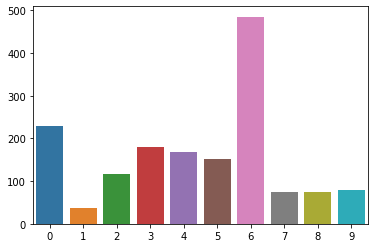

In [18]:
# Define NMF model
nmf_model = NMF(n_components=10, init='random', random_state=25) #init='random',
doc_topics = nmf_model.fit_transform(doc_word)

# Check cluster distribution
doc_cluster = doc_topics.argmax(axis = 1)
sns.barplot(x=pd.Series(doc_cluster).value_counts().keys(),y=pd.Series(doc_cluster).value_counts().values);

In [19]:
display_topics(nmf_model, vectorizer.get_feature_names(), 20)


Topic  0
police, kong police, arrest, officer, say, use, police officer, clash, attack, police say, force, police arrest, people, station, arrest protester, police station, different, june, video, protester police

Topic  1
news, video, national, world, get, coverage, interview, top, online, break, find, abc news, abc, world news, exclusive, news broadcast, news online, national world, broadcast video, broadcast

Topic  2
airport, international, kong airport, flight, international airport, kong international, cancel, day, clash, cancel flight, airport cancel, second, monday, occupy, chaos, one, thousand, protester occupy, second day, cathay

Topic  3
hong kongs, kongs, kongs protest, business, week, storm, take, kongs protester, legislative, law, council, movement, young, day, legislative council, rule, people, pacific, cnn, may

Topic  4
violent, radical, violent protest, radical protester, violence, hk, chinese, violent protester, turn, people, protest hong, kong special, special, f

## Topics by Regions

By looking at the NMF topic modeling result:
These topics are the well defined one.
- Topic 7 (police activities)
- Topic 2 (airport close)
- Topic 4 (violent protest)
- Topic 6 (democracy)
- Topic 5 (extradition bill)

In [20]:
# Created a topic column
df_news_clean['topic'] = doc_topics.argmax(axis=1)

In [21]:
df_news_clean['topic'].value_counts(normalize=True)

6    0.304266
0    0.143664
3    0.113551
4    0.105395
5    0.094730
2    0.072773
9    0.048934
8    0.046424
7    0.046424
1    0.023839
Name: topic, dtype: float64

In [22]:
#creat a table for topic 2,4,5,6,7 agg by percentage by regions
topic_region = pd.DataFrame(df_news_clean[df_news_clean['topic'] == 2]['region'].value_counts(normalize=True))
topic_region = topic_region.merge(df_news_clean[df_news_clean['topic'] == 4]['region'].value_counts(normalize=True), left_index=True,right_index=True)
topic_region = topic_region.merge(df_news_clean[df_news_clean['topic'] == 5]['region'].value_counts(normalize=True), left_index=True,right_index=True)
topic_region = topic_region.merge(df_news_clean[df_news_clean['topic'] == 6]['region'].value_counts(normalize=True), left_index=True,right_index=True)
topic_region = topic_region.merge(df_news_clean[df_news_clean['topic'] == 7]['region'].value_counts(normalize=True), left_index=True,right_index=True)
topic_region.columns = ['airport close','violent protest','extradition bill','democracy','police activities']

In [23]:
topic_region

,airport close,violent protest,extradition bill,democracy,police activities
US,0.448276,0.059524,0.284768,0.410309,0.621622
CN,0.293103,0.857143,0.172185,0.158763,0.040541
HK,0.258621,0.083333,0.543046,0.430928,0.337838


In [24]:
topic_region.reset_index(inplace=True)
topic_region_reshape = pd.melt(topic_region, id_vars='index', var_name="topic", value_name="percentage")

In [25]:
topic_region_reshape

,index,topic,percentage
0,US,airport close,0.448276
1,CN,airport close,0.293103
2,HK,airport close,0.258621
3,US,violent protest,0.059524
4,CN,violent protest,0.857143
5,HK,violent protest,0.083333
6,US,extradition bill,0.284768
7,CN,extradition bill,0.172185
8,HK,extradition bill,0.543046
9,US,democracy,0.410309


/home/bchen/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<Figure size 1800x1080 with 0 Axes>

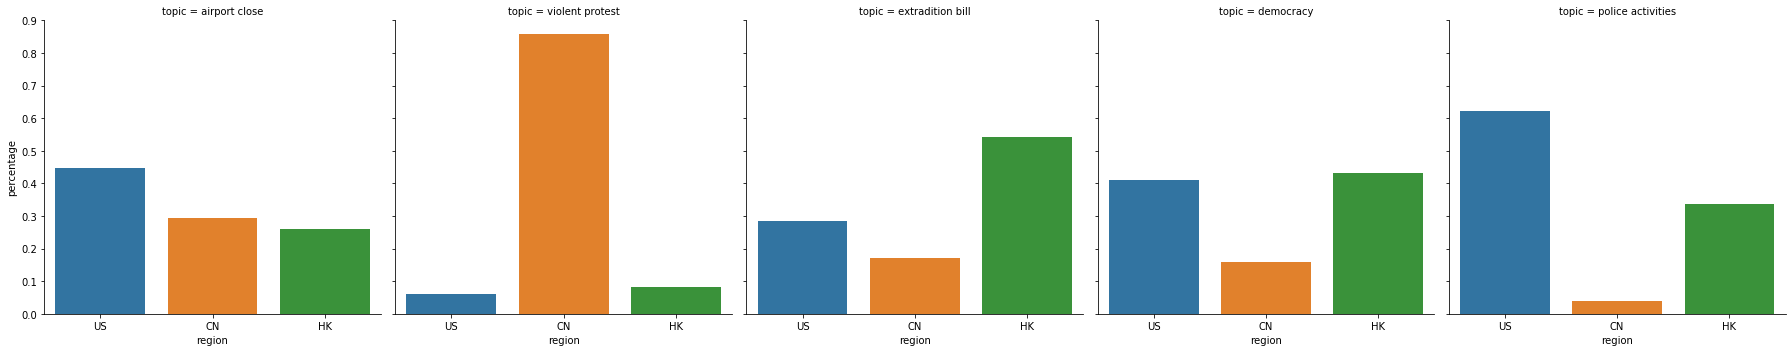

In [26]:
plt.figure(figsize=(25,15))
ax = sns.factorplot("index", "percentage", col="topic", data=topic_region_reshape, kind="bar")
ax.set(xlabel='region')
plt.show()
plt.show()

- HK news outlets focus more 'extradition bill'. 
- US news outlets focus on pro democracy, and police activities 
- China news media focus on critize protesters violent
- China news media does not talk about police actions


# Sentiment Analysis

## Add Sentiment Scores

In [27]:
df_news_clean.shape

(1594, 9)

In [28]:
def countjj(x):
    """count total adjectives from the text"""
    JJcount = 0
    blob = TextBlob(x)
    for word, tag in blob.tags:
        if tag == 'JJ':
            JJcount += 1
    return JJcount


def subjective_score(x):
    """find the subjectivity score from text"""
    blob = TextBlob(x)
    return blob.sentiment.subjectivity
        

In [29]:
# Vader Sentiment Polarity
analyser = SentimentIntensityAnalyzer()
scores =[]
for article in df_news_clean['title_intro']:
    score = analyser.polarity_scores(article)
    scores.append(score)
df_sentiment = pd.DataFrame(scores) # Convert sentiment scores to dataframe

# TextBlob Sentiment Polarity
scores =[]
for article in df_news_clean['title_intro']:
    score = {'txtblob':np.round(TextBlob(article).sentiment.polarity,4)}
    scores.append(score)
df_sentiment_textblob = pd.DataFrame(scores) # Convert sentiment scores to dataframe

# Concat Vader and TextBlob Sentiment DataFrames
df_sentiment = pd.concat([df_sentiment,df_sentiment_textblob],axis=1)


In [30]:
df_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1594 entries, 0 to 1593
Data columns (total 5 columns):
compound    1594 non-null float64
neg         1594 non-null float64
neu         1594 non-null float64
pos         1594 non-null float64
txtblob     1594 non-null float64
dtypes: float64(5)
memory usage: 62.3 KB


In [31]:
# reset all index and merge orginal dataframe and sentiment scores
df_news_clean.reset_index(drop=True, inplace=True)
df_sentiment.reset_index(drop=True, inplace=True)
df_news_sentiment= pd.concat([df_news_clean, df_sentiment], axis=1)

In [32]:
# add two columns: textblob subjectivity score and count of adjective
df_news_sentiment['subjective_score'] = df_news_sentiment['title_intro'].apply(subjective_score)
df_news_sentiment['adjective_count'] = df_news_sentiment['title_intro'].apply(countjj)

In [33]:
df_news_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1594 entries, 0 to 1593
Data columns (total 16 columns):
publisher            1594 non-null object
title                1594 non-null object
intro                1594 non-null object
link                 1594 non-null object
date                 1594 non-null object
region               1594 non-null object
title_intro          1594 non-null object
title_intro_clean    1594 non-null object
topic                1594 non-null int64
compound             1594 non-null float64
neg                  1594 non-null float64
neu                  1594 non-null float64
pos                  1594 non-null float64
txtblob              1594 non-null float64
subjective_score     1594 non-null float64
adjective_count      1594 non-null int64
dtypes: float64(6), int64(2), object(8)
memory usage: 199.3+ KB


## Sentiment Analysis

In [34]:
df_sentiment_groupby = df_news_sentiment.groupby('publisher').agg({'subjective_score': 'mean', 
                        'compound': 'mean','txtblob':'mean'})

In [35]:
df_adjective_groupby = df_news_sentiment.groupby('publisher').agg({'adjective_count': 'mean'}).sort_values("adjective_count")

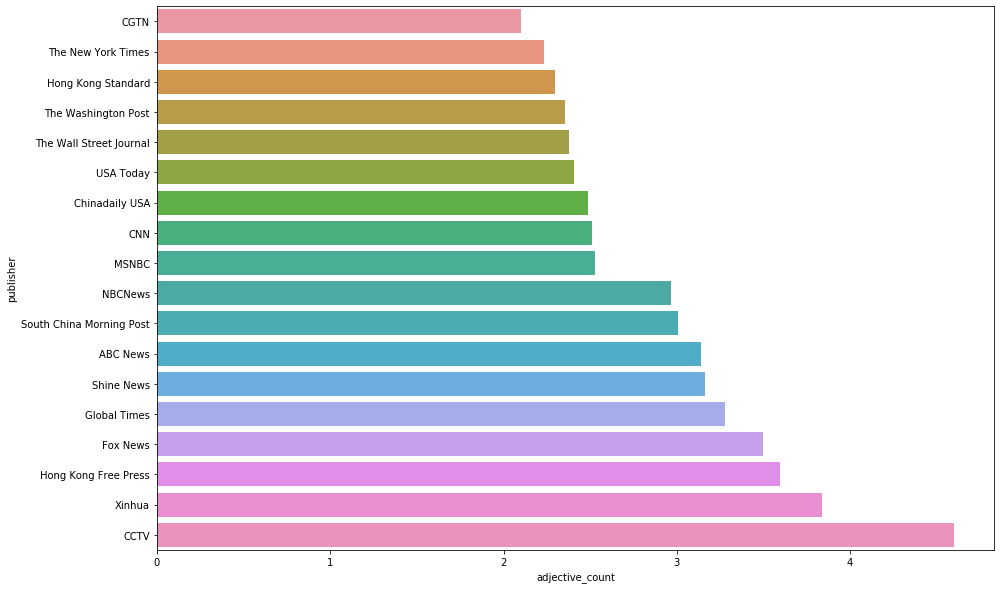

In [36]:
plt.figure(figsize=(15,10))
sns.barplot(y=df_adjective_groupby.index, x=df_adjective_groupby.adjective_count)

From the above adjetive graph
- Chinese news media use more adjectives
- Fox News is the highest among US news outlets.

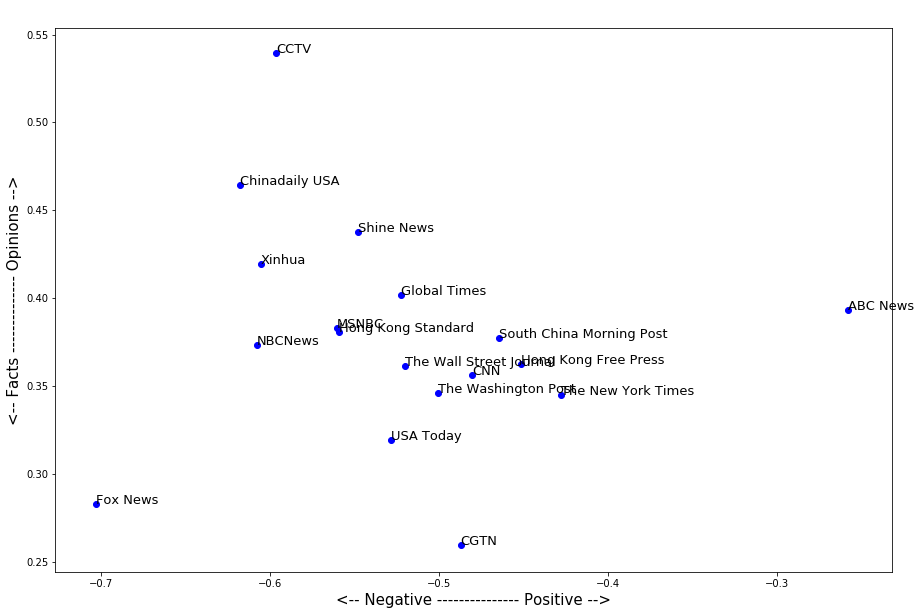

In [37]:
plt.rcParams['figure.figsize'] = [15, 10]

for i, publisher in enumerate(df_sentiment_groupby.index):
    x = df_sentiment_groupby.loc[publisher].values[1]
    y = df_sentiment_groupby.loc[publisher].values[0]
    plt.scatter(x, y, color='blue')
    plt.text(x, y, df_sentiment_groupby.index[i], fontsize=13)
    plt.xlim() 
    
plt.title('Sentiment Analysis', fontsize=20, color='white')
plt.xlabel('<-- Negative --------------- Positive -->', fontsize=15, )
plt.ylabel('<-- Facts -------------- Opinions -->', fontsize=15,)

plt.show()

Looking at the above graph:

- Chinese news outlets are more subjective than most of the others.
- Chinese news outlets have higher negative scores than most of the others.
- US and HK news outlets grouped in the middle.